In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [7]:
import re

import numpy as np
import tensorflow as tf
from transformers import pipeline
import torch

from summarizer import bpe_summarize, sentencizer
from summarizer.validation import scicummnet_validation, rouge_metric, similarity_score, mean_rouge_fscore

INFO:absl:Using tfhub to cache modules.


In [9]:
validation_set = scicummnet_validation("../summarizer/validation/data/scisummnet_release1.1__20190413/")

In [10]:
random_sample = validation_set[np.random.randint(0, len(validation_set))]
assert random_sample is not None

In [11]:
sample_text, human_summary = random_sample
human_summary

'Improving Unsupervised Dependency Parsing with Richer Contexts and Smoothing\nUnsupervised grammar induction models tend to employ relatively simple models of syntax when compared to their supervised counterparts.\nTraditionally, the unsupervised models have been kept simple due to tractability and data sparsity concerns.\nIn this paper, we introduce basic valence frames and lexical information into an unsupervised dependency grammar inducer and show how this additional information can be leveraged via smoothing.\nOur model produces state-of-the-art results on the task of unsupervised grammar induction, improving over the best previous work by almost 10 percentage points.\nWe use the lexical values with the frequency more than 100 and defining tied probabilistic context free grammar (PCFG) and Dirichlet priors, the accuracy is improved.\nWe also implement a sort of parameter tying for the E-DMV through a learning a back off distribution on child probabilities.\n'

In [12]:
bpe_summary = bpe_summarize(sample_text[:1024], percentile=99)
bpe_summary = re.sub(r"\n|\s{2,99}", "", bpe_summary)
bpe_summary

'Traditionally, the unsupervised models have been kept simple due to tractability and data sparsity concerns. Supervised and semisupervised methods now provide highly accurate parsers for a number of languages, but require training from corpora hand-annotated with parse trees.'

In [13]:
mean_rouge_fscore(bpe_summary, human_summary)

0.22346368380637313

In [14]:
similarity_score(bpe_summary, human_summary)

-0.4296875

In [24]:
from transformers import BartTokenizer

# stripped down pipeline to only summarization task
# https://github.com/huggingface/transformers/blob/70bc3ead4f0b08e8cadd1805ada2a22f0c302399/src/transformers/pipelines.py#L1476

def bart_summarizer(text):
    bart_tokenizer: BartTokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
    bart_tokens = bart_tokenizer.encode(text)
    return bart_tokenizer.decode(bart_tokens, skip_special_tokens=True, clean_up_tokenization_spaces=True,)

In [28]:
bart_summary = bart_summarizer(sample_text[:1024])
bart_summary

'\n  Improving Unsupervised Dependency Parsing with Richer Contexts and Smoothing\n  \n    Unsupervised grammar induction models tend to employ relatively simple models of syntax when compared to their supervised counterparts.\n    Traditionally, the unsupervised models have been kept simple due to tractability and data sparsity concerns.\n    In this paper, we introduce basic valence frames and lexical information into an unsupervised dependency grammar inducer and show how this additional information can be leveraged via smoothing.\n    Our model produces state-of-theart results on the task of unsupervised grammar induction, improving over the best previous work by almost 10 percentage points.\n  \n  \n    The last decade has seen great strides in statistical natural language parsing.\n    Supervised and semisupervised methods now provide highly accurate parsers for a number of languages, but require training from corpora hand-annotated with parse trees.\n    Unfortunately, manually 

In [29]:
mean_rouge_fscore(bart_summary, human_summary)

0.7028985457270007

In [31]:
similarity_score(bart_summary, human_summary)

-0.74609375

In [32]:
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [33]:
sample_size = 100

In [36]:
bart_scores = []
bart_summaries = []
for sample_text, human_summary in tqdm(validation_set[:sample_size]):
    bart_summary = bart_summarizer(sample_text[:1024])
    bart_summaries.append(bart_summary)
    bart_scores.append(similarity_score(bart_summary, human_summary))

100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


In [37]:
np.mean(bart_scores)

-0.6517462

In [38]:
bpe_scores = []
bpe_summaries = []
for sample_text, human_summary in tqdm(validation_set[:sample_size]):
    bpe_summary = bpe_summarize(sample_text[:1024], percentile=70)
    bpe_summary = re.sub(r"\s{2,99}", "", bpe_summary)
    bpe_summaries.append(bpe_summary)
    bpe_scores.append(similarity_score(bpe_summary, human_summary))

100%|██████████| 100/100 [00:01<00:00, 89.80it/s]


In [39]:
np.mean(bpe_scores)

-0.5644761

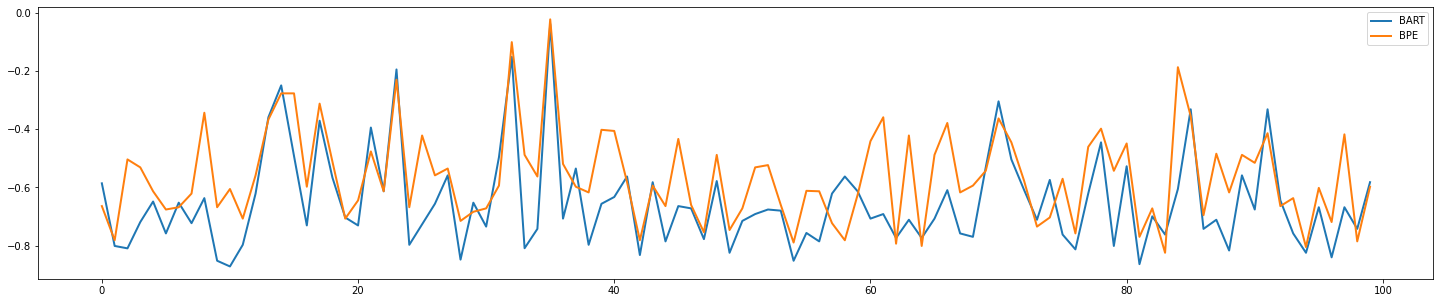

In [40]:
%matplotlib inline
fig = plt.figure(figsize=(25,5))
ax = fig.gca()
ax.plot(np.array(bart_scores), linewidth=2, label='BART')
ax.plot(np.array(bpe_scores), linewidth=2, label='BPE')
ax.legend()

In [41]:
# closer to -1 indicate greater similarity
best_bpe = np.min(bpe_scores)
print(best_bpe)
best = bpe_scores.index(best_bpe)
_,human = validation_set[:sample_size][best]
human

-0.82421875


'Building Deep Dependency Structures Using A Wide-Coverage CCG Parser\nThis paper describes a wide-coverage statistical parser that uses Combinatory Categorial Grammar (CCG) to derive dependency structures.\nThe parser differs from most existing wide-coverage treebank parsers in capturing the long-range dependencies inherent in constructions such as coordination, extraction, raising and control, as well as the standard local predicate-argument dependencies.\nA set of dependency structures used for training and testing the parser is obtained from a treebank of CCG normal-form derivations, which have been derived (semi-) automatically from the Penn Treebank.\nThe parser correctly recovers over 80% of labelled dependencies, and around 90% of unlabelled dependencies.\nWe provide examples showing how heads can fill dependency slots during a derivation, and how long-range dependencies can be recovered through unification of co-indexed head variables.\nWe define predicate argument structure f

In [42]:
bpe_summaries[best]

'Building Deep Dependency Structures Using A Wide-Coverage CCG ParserThis paper describes a wide-coverage statistical parser that uses Combinatory Categorial Grammar (CCG) to derive dependency structures. The parser differs from most existing wide-coverage treebank parsers in capturing the long-range dependencies inherent in constructions such as coordination, extraction, raising and control, as well as the standard local predicate-argument dependencies. A set of dependency structures used for training and testing the parser is obtained from a treebank of CCG normal-form derivations, which have been derived (semi-) automatically from the Penn Treebank. The parser correctly recovers over 80% of labelled dependencies, and around 90% of unlabelled dependencies. However, the dependencies are typically derived from a context-free phrase structu'

In [43]:
# closer to -1 indicate greater similarity
best_bpe = np.min(bart_scores)
print(best_bpe)
best = bart_scores.index(best_bpe)
_,human = validation_set[:sample_size][best]
human

-0.87109375


'Mildly Non-Projective Dependency Structures\nSyntactic parsing requires a fine balance between expressivity and complexity, so that naturally occurring structures can be accurately parsed without compromising efficiency.\nIn dependency-based parsing, several constraints have been proposed that restrict the class of permissible structures, such as projectivity, planarity, multi-planarity, well-nestedness, gap degree, and edge degree.\nWhile projectivity is generally taken to be too restrictive for natural language syntax, it is not clear which of the other proposals strikes the best balance between expressivity and complexity.\nIn this paper, we review and compare the different constraints theoretically, and provide an experimental evaluation using data from two treebanks, investigating how large a proportion of the structures found in the treebanks are permitted under different constraints.\nThe results indicate that a combination of the well-nestedness constraint and a parametric con

In [45]:
bart_summaries[best]

'\n  Mildly Non-Projective Dependency Structures\n  \n    Syntactic parsing requires a fine balance between expressivity and complexity, so that naturally occurring structures can be accurately parsed without compromising efficiency.\n    In dependency-based parsing, several constraints have been proposed that restrict the class of permissible structures, such as projectivity, planarity, multi-planarity, well-nestedness, gap degree, and edge degree.\n    While projectivity is generally taken to be too restrictive for natural language syntax, it is not clear which of the other proposals strikes the best balance between expressivity and complexity.\n    In this paper, we review and compare the different constraints theoretically, and provide an experimental evaluation using data from two treebanks, investigating how large a proportion of the structures found in the treebanks are permitted under different constraints.\n    The results indicate that a combination of the well-nestedness con

In [46]:
t,human = validation_set[:sample_size][best]
result = bpe_summarize(t[:1024], percentile=70)
re.sub(r"\n|\s{2,99}", "", result)
t

'\n  Mildly Non-Projective Dependency Structures\n  \n    Syntactic parsing requires a fine balance between expressivity and complexity, so that naturally occurring structures can be accurately parsed without compromising efficiency.\n    In dependency-based parsing, several constraints have been proposed that restrict the class of permissible structures, such as projectivity, planarity, multi-planarity, well-nestedness, gap degree, and edge degree.\n    While projectivity is generally taken to be too restrictive for natural language syntax, it is not clear which of the other proposals strikes the best balance between expressivity and complexity.\n    In this paper, we review and compare the different constraints theoretically, and provide an experimental evaluation using data from two treebanks, investigating how large a proportion of the structures found in the treebanks are permitted under different constraints.\n    The results indicate that a combination of the well-nestedness con

In [47]:
blob = "The most meaningful part of this sentence is here. I frost apples. Kung fu."
result = bpe_summarize(blob)
result

'The most meaningful part of this sentence is here.'

In [49]:
blob = "The most meaningful part of this sentence is here. I frost apples. Kung fu."
result = bart_summarizer(blob)
result

' The most meaningful part of this sentence is here. I frost apples. Kung fu.'